In [5]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# --- Detailed Gym Docs with Metadata + Timings ---
docs = [
    Document(
        page_content="""
Morning Yoga Class: 6:00 AM - 7:00 AM.
This session focuses on improving flexibility, mindfulness, and breathing control. 
It begins with a 10-minute warm-up, followed by sun salutations, balance poses, and guided meditation. 
Perfect for beginners and advanced yogis alike, this class helps reduce stress and energize you for the day ahead.
""",
        metadata={"source": "yoga_file.txt"}
    ),
    Document(
        page_content="""
Strength Training: 7:30 AM - 9:00 AM.
This class emphasizes building muscle strength and endurance through weight lifting, kettlebell swings, and resistance band exercises. 
The workout is divided into circuits: chest and back on Mondays, legs and shoulders on Wednesdays, and full-body compound lifts on Fridays. 
Each session includes a 15-minute cooldown with stretches to prevent injury.
""",
        metadata={"source": "strength_file.txt"}
    ),
    Document(
        page_content="""
Cardio Blast: 5:00 PM - 6:00 PM.
A high-intensity cardio class designed to improve stamina and burn fat quickly. 
Workouts include treadmill sprints, rowing machine intervals, cycling bursts, and jump rope challenges. 
The class alternates between 1-minute high intensity and 30-second rest periods. 
Recommended for those looking to lose weight and build endurance after work hours.
""",
        metadata={"source": "cardio_file.txt"}
    ),
    Document(
        page_content="""
Evening Zumba: 6:30 PM - 7:30 PM.
A dance-based fitness class featuring Latin music and fast-paced choreography. 
This fun session is structured with warm-up routines, high-energy dance sequences, and a cooldown stretch. 
It is ideal for anyone wanting to burn 500–700 calories in one session while enjoying music. 
No prior dance experience required. Perfect way to end the day with energy and positivity.
""",
        metadata={"source": "zumba_file.txt"}
    ),
    Document(
        page_content="""
Gym Facilities and Closing Hours:
Our gym is open daily from 5:30 AM to 10:00 PM. 
We provide a sauna and steam room facility, available from 8:00 PM to 9:30 PM for relaxation and muscle recovery. 
The gym also includes a protein shake bar that operates from 7:00 AM to 9:00 AM in the morning and 6:00 PM to 8:00 PM in the evening. 
Personal trainers are available between 6:00 AM to 9:00 AM and 5:00 PM to 8:00 PM for customized guidance.
""",
        metadata={"source": "facilities_file.txt"}
    ),
    Document(
        page_content="""
Nutrition & Diet Guidance:
Daily consultation timings are from 10:00 AM - 12:00 PM. 
Our certified dietitians provide personalized diet charts based on your fitness goals. 
For weight loss, the plan emphasizes high-protein breakfasts, low-carb lunches, and balanced dinners. 
For muscle gain, it includes post-workout protein shakes, calorie-dense snacks, and proper hydration strategies. 
Weekly diet follow-up sessions are scheduled every Friday at 11:00 AM.
""",
        metadata={"source": "nutrition_file.txt"}
    )
]

db = Chroma.from_documents(docs, embedding_function)

In [6]:
retriever = db.as_retriever(search_type="mmr", search_kwargs={"k":3})

In [ ]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

retriever_tool = create_retriever_tool(
    retriever,
    "retriever_tool",
    "Information related to Gym History & Founder, Operating Hours, Membership Plans, Fitness Classes, Personal Trainers, Facilities & Equipment of Peak Performance Gym",
)

@tool
def off_topic():
    """Catch all Questions NOT related to Peak Performance Gym's history, hours, membership plans, fitness classes, trainers, or facilites"""
    return "Forbidden - do not respond to the user"

tools = [retriever_tool, off_topic]

In [8]:
from typing import Annotated, Sequence, Literal, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [15]:
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import END, StateGraph, START
import os
from dotenv import load_dotenv

load_dotenv()

def agent(state):
    messages = state["messages"]
    model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY"))
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}

def should_continue(state) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls: 
        return "tools"
    return END 


In [16]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

workflow = StateGraph(AgentState)
workflow.add_node("agent", agent)

tool_node = ToolNode(tools)
workflow.add_node("tools", tool_node)
workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)

workflow.add_edge("tools", "agent")

graph = workflow.compile()

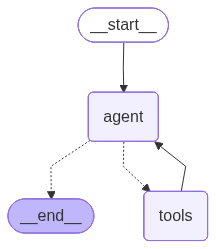

In [17]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [18]:
graph.invoke(
    input={"messages": [HumanMessage(content="who is openai owner")]}
)

ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.tools[0].function_declarations[0].name: Invalid function name. Must start with a letter or an underscore. Must be alphameric (a-z, A-Z, 0-9), underscores (_), dots (.), colons (:), or dashes (-), with a maximum length of 64.


In [19]:
graph.invoke(input={
    "messages": [HumanMessage(content="what are the timings?")]
})

ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.tools[0].function_declarations[0].name: Invalid function name. Must start with a letter or an underscore. Must be alphameric (a-z, A-Z, 0-9), underscores (_), dots (.), colons (:), or dashes (-), with a maximum length of 64.
